## BII Phoenix Analysis

More information on this analysis is available at: 
https://github.com/annieradams/bii-phoenix

#### Load necessary packages

In [1]:
import numpy as np
import geopandas as gpd 
import rioxarray as rioxr
import matplotlib.pyplot as plt
import rasterio

from shapely.geometry import Polygon

#used to access STAC catalogs
from pystac_client import Client
#used to sign items from the MPC STAC catalog
import planetary_computer

# other libraries for nice outputs
from IPython.display import Image


import contextily as cx
from matplotlib.colors import ListedColormap

import matplotlib.lines as mlines
import matplotlib.patches as mpatches # for creating legends
##


#### Load data

We will access the BII data using the planetary computer's database, and access the Arizona shapefile using the shapefile loaded in our data folder.

In [2]:
#access catalog
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1',
                     modifier = planetary_computer.sign_inplace)


In [3]:

#bounds:
bbox = [-112.826843, 32.974108, -111.184387, 33.863574] # create phoenix bounding box



#Catalog search 
search = catalog.search(
    collections = ['io-biodiversity'], # pull biodiversity data from catalog search
    bbox= bbox, # include bounding box of phoenix
)

bii = search.item_collection() # get collection of bii
bii_2020 = bii[0] # select 2020 year
bii_2017 = bii[3] # select 2017 year

In [4]:
# load in phoenix subdivision shapefile
arizona = gpd.read_file('data/tl_2022_04_cousub/tl_2022_04_cousub.shp') # read in shapefile of arizona counties
phoenix = arizona[arizona.NAME == "Phoenix"] # select phoenix county 
 
#check to make sure there is only one unique value (row) for phoenix
(phoenix.shape)[0] == 1 

True

#### Use contexily to create a map of the Phoenix subdivision
Contextily is a python library to add basemaps.It retrieves tile maps from the internet and makes it possible to plot them alongside our vector data. Let's look at the phoenix subdivision using contextily.


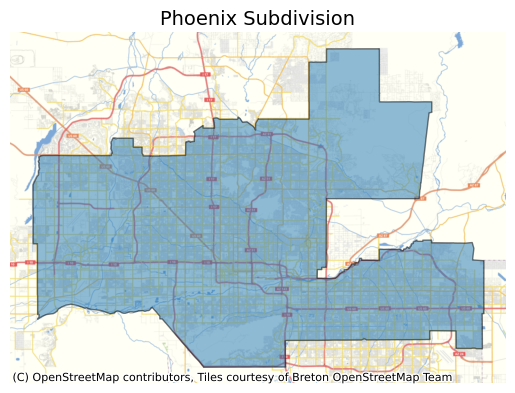

In [5]:
fig, ax = plt.subplots()
(phoenix.to_crs(epsg=3857)
 .plot(ax=ax, figsize =(10,10), alpha =0.5, edgecolor="k")
)
#Adding Basemap
cx.add_basemap(ax, source = cx.providers.OpenStreetMap.BZH) 
ax.set_title('Phoenix Subdivision', fontdict = {'fontsize':'14'})
ax.set_axis_off()

#### Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 for both 2017 and 2020

In [6]:
for key, asset in bii_2017.assets.items(): # get asset names for future extraction
    print(key, '-', asset.title)

data - Biodiversity Intactness
tilejson - TileJSON with default rendering
rendered_preview - Rendered preview


##### Obtain 2017 and 2020 BII data to see how percentage of BII has changed over time:

We can create a raster of bii data greater than .75 for 2017 and 2020 by filtering for bii >= .75. Doing so will provide us with an xarray of true/falses, true if that the bii was greater than .75 for each pixel, and false if not. To be able to add these values/ find total number of pixels as "true" , we can convert the xarray to be an integer isntead, where 1 denotes true and 0 denotes false. Summing the number of 1's over the total number of pixels will tell us what percent of Phoenix had a BII greater than .75 in 2017/2020.

In [7]:
#calculate 2017

bii_2017_data = rioxr.open_rasterio(bii_2017.assets['data'].href) # get 2017 data 
bii_2017_data

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [8]:


bii_2017_greater_75 = bii_2017_data >= .75 # select BII greater than .75
bii_2017_greater_75 = bii_2017_greater_75.squeeze().drop('band') # drop the band for future plotting purposes
bii_2017_greater_75 = bii_2017_greater_75.astype(int) # use astype to turn true/falses into 1s and 0s

#get percent of values greater than .75 by dividing by total pixels
bii_2017_percent = (np.sum(bii_2017_greater_75)/(np.sum(bii_2017_data)))* 100 
bii_2017_percent = round(bii_2017_percent.values.item(),2)
bii_2017_percent
print("The percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 is", bii_2017_percent, "%.")

The percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 is 91.13 %.


In [9]:
#calculate 2020
bii_2020_data = rioxr.open_rasterio(bii_2020.assets['data'].href) # get 2020 data 



bii_2020_greater_75 = bii_2020_data >= .75 # select BII greater than .75
bii_2020_greater_75 = bii_2020_greater_75.squeeze().drop('band') # drop the band for future plotting purposes
bii_2020_greater_75 = bii_2020_greater_75.astype(int) # use astype to turn true/falses into 1s and 0s



#get percent of values greater than .75 by dividing by total pixels
bii_2020_percent = (np.sum(bii_2020_greater_75)/(np.sum(bii_2020_data)))* 100 
bii_2020_percent = round(bii_2020_percent.values.item(),2)
bii_2020_percent
print("The percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2020 is", bii_2020_percent, "%.")

The percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2020 is 91.02 %.


In [10]:
bio_loss = bii_2017_greater_75 - bii_2020_greater_75 # subtract 2020 raster from 2017 to get difference raster
#bio_loss = bio_loss.squeeze().drop('band')


#### Visualization of biodiversity loss from 2017 to 2020

We can create a raster of the lost biodiveristy from 2017 to 2020 and add it on top of other rasters ( in this case, we can add on top of 2017 or 2020 Biodiversity data). Doing so will allow us to visualize where and how much the biodiversity intactness index was impacted. 

In [11]:
bio_loss.rio.crs

CRS.from_epsg(4326)

In order to plot these rasters together, we need to make sure they have the same crs.

In [12]:
bio_loss.rio.crs == phoenix.crs # check if crs are different 
phoenix = phoenix.to_crs(bio_loss.rio.crs) # crs do not match so make phoenix crs same as bio_loss crs
bio_loss.rio.crs == phoenix.crs #check again to make sure crs now match

True

For plotting conciseness, we want to make our bii data and our bii loss data be the shape of Phoenix county

In [13]:

bio_loss_phoenix = bio_loss.rio.clip(phoenix.geometry, phoenix.crs) # clip bio loss to size of phoenix shapefile
bii_2020_phoenix = bii_2020_data.rio.clip(phoenix.geometry, phoenix.crs) # clip original bii 2020 data to size of phoenix shapefile
bii_2020_phoenix = bii_2020_phoenix.squeeze().drop('band') # drop the band for future plotting purposes/
 


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


We can create a graph below showing the 2020 biodiversity intactness index in Phoenix County. On top of this map, we will plot the loss in biodiversity from 2017 to 2020. 

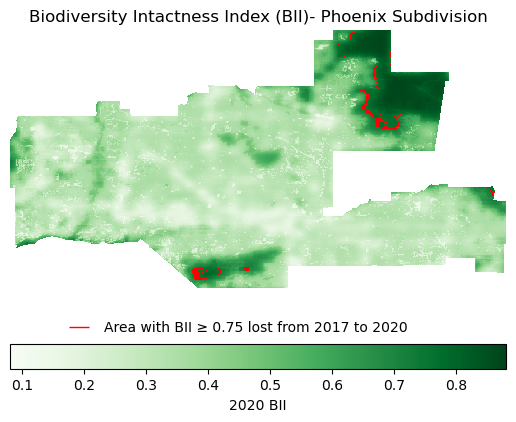

In [14]:

bii_2020_phoenix = bii_2020_phoenix.rio.clip(phoenix.geometry, phoenix.crs) # clip bii index to phoenix shapefile
cmap = ListedColormap(['none', 'red']) # assign values to none for Na and red otherwise 
#---------------------------
fig,ax = plt.subplots()
ax.axis('off') # turn x and y axis off
bii_2020_phoenix.plot.imshow(ax= ax, 
                             add_colorbar=True,  # legend colorbar
                             cmap = 'Greens',  # change color to green 
                                cbar_kwargs={'label': '2020 BII',   # name of legend 
                                                     'orientation': 'horizontal'}) #make legend horizontal
bio_loss_phoenix.where(bio_loss_phoenix == 1).plot.imshow(add_colorbar = False, cmap = cmap) # plot values that are equal to 1 ( values that had biodiversity >= .75 in 2017 but not 2020


bio_loss_line = mlines.Line2D([], [], color='red',marker = "_", # make legend have triangle #update legend name and marker
                          markersize=15, label='Area with BII \u2265 0.75 lost from 2017 to 2020', linestyle = 'None')

#---------------------------

# create legend
ax.legend(handles = [bio_loss_line], frameon = False, loc = (0.1,-.2)) # add legend onto map


#---------------------------


plt.title("Biodiversity Intactness Index (BII)- Phoenix Subdivision") # create title
plt.show()


